<a href="https://colab.research.google.com/github/jazu1412/APACHE_BEAM/blob/main/Social_media_interaction_apache_beam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Apache Beam Features Demonstration

## Introduction
##This notebook demonstrates key features of Apache Beam, including composite transforms, pipeline I/O, triggers, windowing, ParDo, and streaming. We'll use a sample dataset of social media interactions to showcase these features.

## Step 1: Setup and Dataset Creation

# Install Apache Beam
!pip install apache-beam[gcp]
import apache_beam as beam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.5/173.5 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.8/193.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.7/184.7 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:

# Import necessary libraries
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.io import ReadFromText, WriteToText
from apache_beam.transforms.window import FixedWindows
from apache_beam.transforms import WindowInto
from apache_beam.transforms.trigger import AfterCount, Repeatedly
import matplotlib.pyplot as plt
import networkx as nx


In [2]:

# Create a sample dataset
sample_data = """
timestamp,action,engagement
2023-11-01 09:00:00,post,10
2023-11-01 09:05:00,like,2
2023-11-01 09:10:00,share,5
2023-11-01 09:15:00,comment,3
2023-11-01 09:20:00,post,15
2023-11-01 09:25:00,like,4
2023-11-01 09:30:00,share,7
2023-11-01 09:35:00,comment,6
"""

with open("social_media_interactions.csv", "w") as file:
    file.write(sample_data)

print("Sample dataset created successfully.")


Sample dataset created successfully.


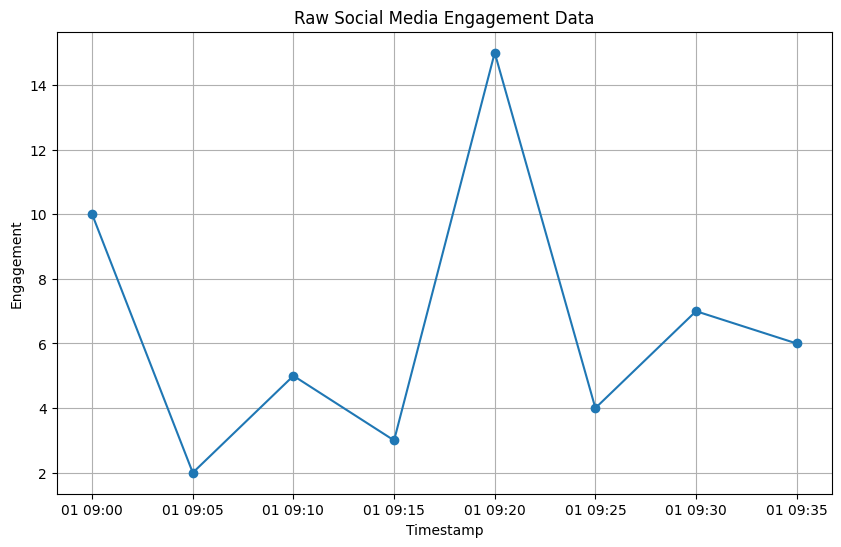

In [12]:


import matplotlib.pyplot as plt
import pandas as pd

# Load the data into a Pandas DataFrame
df = pd.read_csv("social_media_interactions.csv")

# Convert the timestamp column to datetime objects
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df["timestamp"], df["engagement"], marker="o")
plt.xlabel("Timestamp")
plt.ylabel("Engagement")
plt.title("Raw Social Media Engagement Data")
plt.grid(True)
plt.show()


In [3]:

## Step 2: Define ParDo Function

# ParDo function to extract action and its associated engagement
class ExtractActionEngagementFn(beam.DoFn):
    def process(self, element):
        parts = element.split(',')
        if len(parts) == 3:
            _, action, engagement = parts
            yield (action.strip(), int(engagement.strip()))

print("ParDo function defined.")


ParDo function defined.


In [4]:

## Step 3: Define Composite Transform

# Composite transform to extract action and calculate total engagement
class ExtractAndSumEngagement(beam.PTransform):
    def expand(self, pcoll):
        return (
            pcoll
            | 'ExtractActionEngagement' >> beam.ParDo(ExtractActionEngagementFn())
            | 'SumEngagement' >> beam.CombinePerKey(sum)
        )

print("Composite transform defined.")


Composite transform defined.


In [5]:

## Step 4: Define Pipeline

def run_pipeline():
    # Set up the pipeline options
    options = PipelineOptions()
    p = beam.Pipeline(options=options)

    # Read from the input file (Pipeline I/O)
    interactions = (
        p
        | 'ReadFromFile' >> ReadFromText('social_media_interactions.csv')
        | 'SkipHeader' >> beam.Filter(lambda x: not x.startswith('timestamp'))
        # Windowing and Trigger
        | 'WindowInto5MinWithTrigger' >> beam.WindowInto(
            FixedWindows(300),  # 5 minutes
            trigger=Repeatedly(AfterCount(3)),
            accumulation_mode=beam.transforms.trigger.AccumulationMode.DISCARDING
        )
    )

    # Apply the composite transform
    processed_interactions = interactions | 'ProcessInteractions' >> ExtractAndSumEngagement()

    # Write to the output file (Pipeline I/O)
    processed_interactions | 'WriteToOutput' >> WriteToText('output_interactions.txt')

    # Run the pipeline
    result = p.run()
    result.wait_until_finish()


In [6]:

# Execute the pipeline
if __name__ == '__main__':
    run_pipeline()

print("Pipeline executed successfully.")


Pipeline executed successfully.


In [8]:

## Step 5: Visualize Results

# Read and process the results
with open("output_interactions.txt", "r") as file:
    lines = file.readlines()

actions, engagements = [], []
for line in lines:
    action, engagement = line.strip().split(',')
    actions.append(action.strip("'"))
    engagements.append(int(engagement))


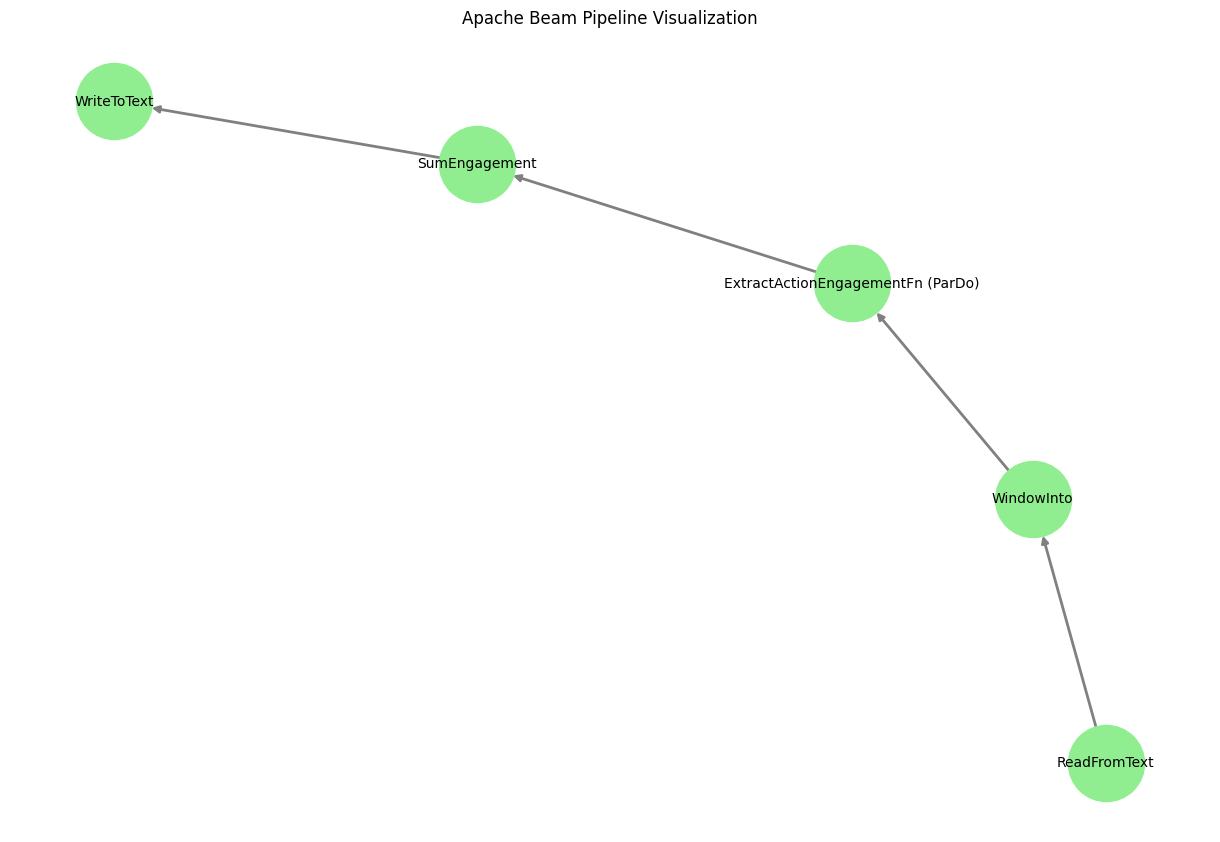

Visualization complete.


In [10]:

## Step 6: Visualize Pipeline

# Create a directed graph
G = nx.DiGraph()

# Nodes represent stages or transforms in the pipeline
nodes = ["ReadFromText", "WindowInto", "ExtractActionEngagementFn (ParDo)", "SumEngagement", "WriteToText"]
G.add_nodes_from(nodes)

# Edges represent data flow
edges = [("ReadFromText", "WindowInto"),
         ("WindowInto", "ExtractActionEngagementFn (ParDo)"),
         ("ExtractActionEngagementFn (ParDo)", "SumEngagement"),
         ("SumEngagement", "WriteToText")]
G.add_edges_from(edges)

# Draw the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightgreen", font_size=10, width=2, edge_color="gray")
plt.title("Apache Beam Pipeline Visualization")
plt.show()

print("Visualization complete.")